# Test wrap Keras model into a scikit-learn model
This operation will be useful to build hybrid models which will consist in a sklearn Pipeline of a neural network (typically a trained VAE) and a shallow model (typically random forest classifier that works in the latent space).

In [188]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# # DRIVE
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC, plot_history

from uad.models.hybrid import hybrid

# !nvidia-smi

2.2.0


In [189]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 1

x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-1000], binarize_set(y_train[np.where(y_train[:-1000] == interest_digit)][:-1000], interest=interest_digit)
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

(5640, 28, 28, 1) (5640,) (1000, 28, 28, 1) (1000,)


In [190]:
from uad.models.variational_autoencoder import ConvolutionalVAE

auc_callback = AUCCallback(x_val, y_val_bin, criterion="l2")

vae = ConvolutionalVAE(8)
vae.compile(optimizer=tf.keras.optimizers.Adam())
history = vae.fit(x_train_bin, validation_data=(x_val, x_val), epochs=10, batch_size=64, callbacks=[auc_callback])

Epoch 1/10
89/89 [==============================] - ETA: 0s - loss: 225.2381 - reconstruction_loss: 224.7173 - kl_loss: 0.5208
AUC = 0.5
89/89 [==============================] - 16s 179ms/step - loss: 224.8362 - reconstruction_loss: 224.3136 - kl_loss: 0.5226 - val_reconstruction_loss: 275.1053 - val_accuracy: 0.5000
Epoch 2/10
89/89 [==============================] - ETA: 0s - loss: 123.4212 - reconstruction_loss: 121.7198 - kl_loss: 1.7014
AUC = 0.5
89/89 [==============================] - 16s 176ms/step - loss: 123.2032 - reconstruction_loss: 121.5022 - kl_loss: 1.7010 - val_reconstruction_loss: 272.8808 - val_accuracy: 0.5000
Epoch 3/10
88/89 [============================>.] - ETA: 0s - loss: 84.4982 - reconstruction_loss: 82.5023 - kl_loss: 1.9959- ETA: 6s - loss: 92.5345 - reconstr
AUC = 0.720588207244873
89/89 [==============================] - 15s 167ms/step - loss: 83.7768 - reconstruction_loss: 81.7749 - kl_loss: 2.0019 - val_reconstruction_loss: 268.1034 - val_accuracy: 0.72

(<Figure size 1440x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d246f12cc8>)

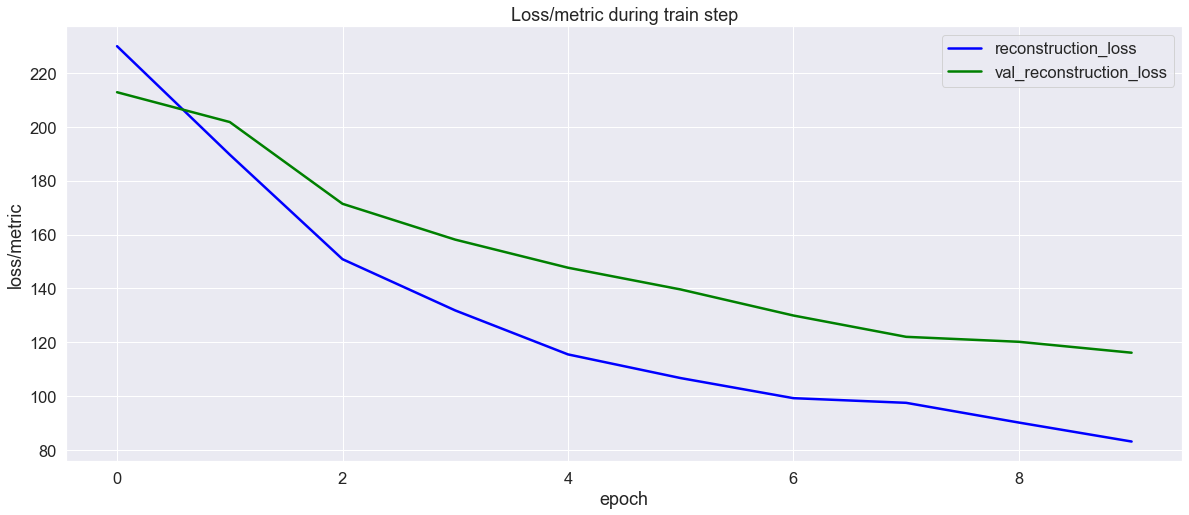

In [27]:
plot_history(history, metric_names=np.array([["reconstruction_loss", "val_reconstruction_loss"]]))

In [ ]:
# predictions = vae.predict(x_test)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d2476b3908>)

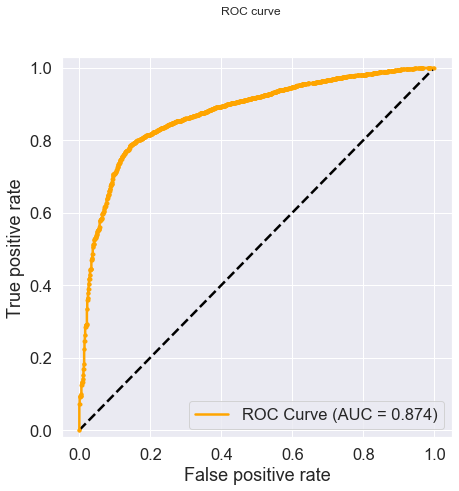

In [41]:
fprs, tprs, _ = compute_ROC(x_test, predictions, y_test_bin)
plot_ROC(fprs, tprs, labels=["ROC Curve"])

## Compare the predictions of {decoder, reconstruction loss} and {RandomForestClassifier}

The RFC is trained on the predictions of the encoder of the trained VAE on the x_train_bin set (intelligent de faire ça?). Its task is to predict the label of a point (anormal or not) from the z_mean predicted by the encoder.

In [53]:
# predictions encoder + decoder + reconstructions error
z_means, z_log_vars, zs = vae.encoder.predict(x_test)
predictions = vae.decoder.predict(zs)
y_pred = is_anormal(x_test, predictions, criterion="l2")

In [64]:
# predictions encoder + RandomForest on z_means 
from sklearn.svm import OneClassSVM
z_means_train, zlv_train, _ = vae.encoder.predict(x_train_bin)
z_means_train = np.reshape(z_means_train, (z_means_train.shape[0], 4*4*8))
print(z_means_train.shape)
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(z_means_train)

(4853, 128)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False)

In [68]:
z_means_vect = np.reshape(z_means, (z_means.shape[0], 4*4*8)) # enc predictions
y_pred_scores = clf.score_samples(z_means_vect)
roc = roc_curve(1 - y_test_bin, y_pred_scores)

Text(0.5, 0.98, '0.8591829951801064')

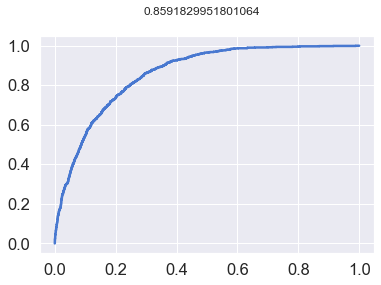

In [70]:
from sklearn.metrics import roc_auc_score
plt.plot(roc[0], roc[1])
plt.suptitle(roc_auc_score(1 - y_test_bin, y_pred_scores))

In [196]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.svm import OneClassSVM
from uad.models.variational_autoencoder import ConvolutionalVAE


class OCHybrid(BaseEstimator, OutlierMixin):
    """
    Hybrid model that takes a pretrained encoder (typically the encoder part of a VAE) and predicts
    anomalies from the encoded signal. Warning : the following the convention is adopted 1 for
    anomalies and 0 for normal. This is opposite to the sklearn convention
    """

    def __init__(self, encoder=None, params={}):
        """
        :param encoder: model that implements predict(batch) --> z_means, z_log_vars, zs
        :param params: additional parameters for the OneClassSVM part
        """
        self.encoder = encoder
        self.svm = OneClassSVM(**params)
        self.svm_fitted_ = False

    def binarize(self, Z):
        """
        Convert from sklearn convention {anormal: -1, normal: 1} to our convention {anormal:1,
        normal:0}
        :param Z:
        :return:
        """
        l = []
        for elt in Z:
            if elt == -1:
                l.append(1)
            else:
                l.append(0)
        return np.array(l)

    def encode(self, x):
        """
        Encode the given images and returns a batch of vectors
        :param x: original input
        :return: flatten encoded input
        """
        if len(x.shape) != 3 and len(x.shape) != 4:
            raise NotImplementedError("Input tensor should be either (None, x, y, z) or (None, x, y)")

        z_means, z_log_vars, zs = self.encoder.predict(x)

        if len(z_means.shape) == 1:  # flat vector of real numbers
            batch = z_means.shape[0]
            z_m = np.reshape(z_means, (batch, 1))
        else:
            batch, flatten = z_means.shape[0], np.prod(z_means.shape[1:])
            z_m = np.reshape(z_means, (batch, flatten))

        return z_m

    def fit(self, x_train):
        """
        encode the train set into the appropriate format for the OC-
        SVM to be trained
        :param x_train: original train dataset. x_train should be either (None, x, y, z)
        (batch of 3-tensor) or (None, x, y) (batch of matrices)
        :return:
        """
        z_m_train = self.encode(x_train)

        self.svm.fit(z_m_train)
        self.svm_fitted_ = True
        return self

    def fit_predict(self, x_train):
        z_m_train = self.encode(x_train)

        self.svm.fit(z_m_train)
        self.svm_fitted_ = True
        return self.binarize(self.svm.predict(z_m_train))

    def predict(self, x):
        z_m = self.encode(x)

        return self.binarize(self.svm.predict(z_m))

    def score_samples(self, x):
        """
        In sklearn convention, a lower score indicates an anomaly. In our convention this is
        the opposite.
        :return: anomaly score function on x
        """
        z_m = self.encode(x)
        score = self.svm.score_samples(z_m)
        return score

    def score(self, x, y_true):
        z_m = self.encode(x)
        y_pred = self.binarize(self.svm.predict(z_m))
        return roc_auc_score(y_true, y_pred)

    def decision_function(self, x):
        z_m = self.encode(x)
        return self.svm.decision_function(z_m)

    def plot_tSNE(self, x, y_true):
        z_m = self.encode(x)
        y_pred = self.svm.predict(z_m)
        x_embedded = TSNE(n_components=2).fit_transform(z_m)
        y_scores = self.score_samples(x)

        # choose a color palette with seaborn.
        num_classes = len(np.unique(y_true))
        palette = np.array(sns.color_palette("hls", num_classes))

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

        # create meshgrid
        resolution = 300  # 100x100 background pixels
        x2d_xmin, x2d_xmax = np.min(x_embedded[:, 0]), np.max(x_embedded[:, 0])
        x2d_ymin, x2d_ymax = np.min(x_embedded[:, 1]), np.max(x_embedded[:, 1])
        xx, yy = np.meshgrid(np.linspace(x2d_xmin, x2d_xmax, resolution), np.linspace(x2d_ymin, x2d_ymax, resolution))

        # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
        background_model = KNeighborsClassifier(n_neighbors=1).fit(x_embedded, y_pred)
        voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
        voronoiBackground = voronoiBackground.reshape((resolution, resolution))

        # plot
        ax.set_title("t-SNE projection of the points and decision function")
        plt.pcolormesh(xx, yy, voronoiBackground, cmap=plt.cm.Paired)
        #                     levels=[-.5, 0, .5])
        ax.contourf(xx, yy, voronoiBackground, cmap=plt.cm.Paired)
        ax.scatter(x_embedded[:, 0], x_embedded[:, 1], c=palette[y_true.astype(np.int)])
        plt.colorbar()


In [197]:
oc = OCHybrid(vae.encoder, {"nu":0.1, "kernel":"rbf", "gamma":0.1})
oc.fit(x_train_bin)

C:\Users\Hugo\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


OCHybrid(encoder=<tensorflow.python.keras.engine.training.Model object at 0x000001D2267C4108>,
         params=None)

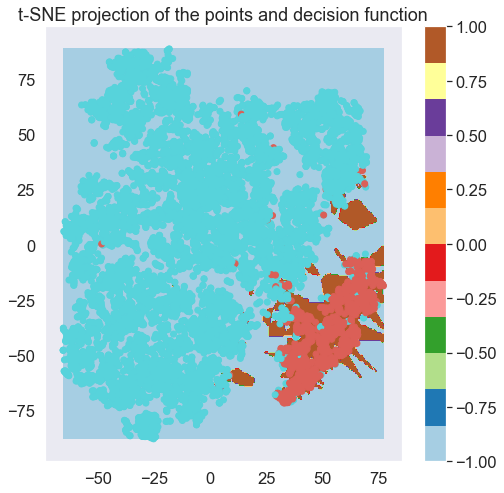

In [198]:
oc.plot_tSNE(x_test, y_test_bin)

Text(0.5, 0.98, 'Models predictions for digit 1')

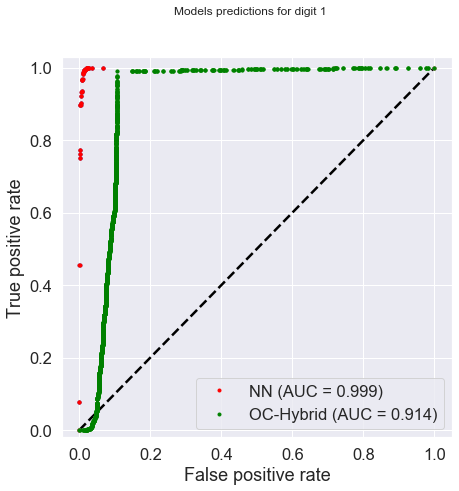

In [202]:
# nn_fpr, nn_tpr, _ = compute_ROC(x_test, vae.predict(x_test), y_test_bin)
# svm_fpr, svm_tpr, _ = compute_ROC(x_test, oc.predict(x_test), y_test_bin)

plot_ROC(np.array([nn_fpr, svm_fpr]), np.array([nn_tpr, svm_tpr]), labels=["NN", "OC-Hybrid"])
plt.suptitle("Models predictions for digit 1")